In [1]:
from fastai.collab import *
from fastai.tabular import *

In [2]:
torch.cuda.set_device(1) # local GPU server의 두번째 RTX 2070 Ti에 할당.

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [3]:
user,item,title = 'userId','movieId','title' # movie lens dataset에 있는 column들.

In [4]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/user/.fastai/data/movie_lens_sample')

In [5]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [6]:
data = CollabDataBunch.from_df(ratings, seed=42) # Collaborative Filtering을 위한 데이터 loader.

In [7]:
y_range = [0,5.5]

In [8]:
# forward 결과로 나올 수 있는 y값을 0 ~ 5.5 사이의 값으로 지정한 뒤 학습. 50개의 factor를 사용.
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [9]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.614950,0.912833,00:00
1,0.849642,0.684250,00:00
2,0.652708,0.667802,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [10]:
path=Config.data_path()/'ml-100k' # movie lens 100k 데이터 파일 load.

In [11]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [12]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
len(ratings)

100000

In [14]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [15]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title) # random seed 42, validation data 10%, shuffle.

In [16]:
data.show_batch()

userId,title,target
642,Nine Months (1995),3.0
246,Fantasia (1940),3.0
591,Tin Men (1987),3.0
198,2001: A Space Odyssey (1968),5.0
194,Home Alone (1990),3.0


In [17]:
y_range = [0,5.5]

In [18]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


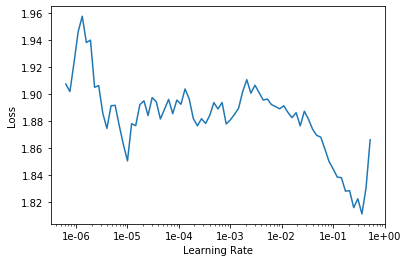

In [19]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [20]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.954044,0.943622,00:03
1,0.863018,0.886101,00:03
2,0.782958,0.837158,00:03
3,0.657309,0.816525,00:03
4,0.534203,0.815179,00:03


In [21]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [22]:
learn.load('dotprod');

In [23]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [24]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10] # rating이 높은 영화 10개를 정렬.

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [25]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [26]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [27]:
item0 = lambda o:o[0]

In [28]:
sorted(movie_ratings, key=item0)[:15] # movie_bias 값을 받아서 낮은 순으로 정렬하여 15개를 출력.

[(tensor(-0.3714),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3469),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2897), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2554), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2511), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2503), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2434), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2431), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2262), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2258), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2216), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2209), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2199), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2194), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.

In [29]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15] # movie_bias 값을 받아서 높은 순으로 정렬하여 15개를 출력.

[(tensor(0.6237), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5837), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5648), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5367), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5299), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5257), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5230), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4923), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4916), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4913), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4804), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4793), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4747), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4693), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4679), 'Boot, Das (1981)', 4.203980099502488)]

### Movie weights

In [30]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [31]:
movie_pca = movie_w.pca(3) # 시각화를 위해 3차원으로 차원 감소.
movie_pca.shape

torch.Size([1000, 3])

In [32]:
fac0,fac1,fac2 = movie_pca.t() # 각 차원별값들을 column으로 하여 fac0, fac1, fac2로 저장.
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [33]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2317), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.2132), 'Jungle2Jungle (1997)'),
 (tensor(1.2030), 'Home Alone 3 (1997)'),
 (tensor(1.1882), 'Leave It to Beaver (1997)'),
 (tensor(1.1865), 'Bio-Dome (1996)'),
 (tensor(1.1816), "McHale's Navy (1997)"),
 (tensor(1.1596), 'Free Willy 3: The Rescue (1997)'),
 (tensor(1.1389), 'Flipper (1996)'),
 (tensor(1.0823), 'Congo (1995)'),
 (tensor(1.0658), 'Richie Rich (1994)')]

In [34]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0815), 'Casablanca (1942)'),
 (tensor(-1.0670), 'Close Shave, A (1995)'),
 (tensor(-1.0384), 'Chinatown (1974)'),
 (tensor(-1.0166), 'Wrong Trousers, The (1993)'),
 (tensor(-1.0130), 'Lawrence of Arabia (1962)'),
 (tensor(-0.9679), 'Godfather, The (1972)'),
 (tensor(-0.9483), 'When We Were Kings (1996)'),
 (tensor(-0.9475), 'Persuasion (1995)'),
 (tensor(-0.9421), 'Ran (1985)'),
 (tensor(-0.9374), 'Third Man, The (1949)')]

In [35]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [36]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9001), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8560), 'Keys to Tulsa (1997)'),
 (tensor(0.8205), 'Jude (1996)'),
 (tensor(0.8119), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.8067), 'Clockwork Orange, A (1971)'),
 (tensor(0.7986), 'Stupids, The (1996)'),
 (tensor(0.7954), 'Dracula: Dead and Loving It (1995)'),
 (tensor(0.7634), 'Brazil (1985)'),
 (tensor(0.7315), 'Stuart Saves His Family (1995)'),
 (tensor(0.7280), 'Trainspotting (1996)')]

In [37]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1893), 'Braveheart (1995)'),
 (tensor(-1.1152), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.0740), 'Titanic (1997)'),
 (tensor(-0.9122), 'Star Wars (1977)'),
 (tensor(-0.8807), 'Forrest Gump (1994)'),
 (tensor(-0.8804), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8788), 'Return of the Jedi (1983)'),
 (tensor(-0.8724), 'Sleepless in Seattle (1993)'),
 (tensor(-0.8709), 'Hunt for Red October, The (1990)'),
 (tensor(-0.8416), "It's a Wonderful Life (1946)")]

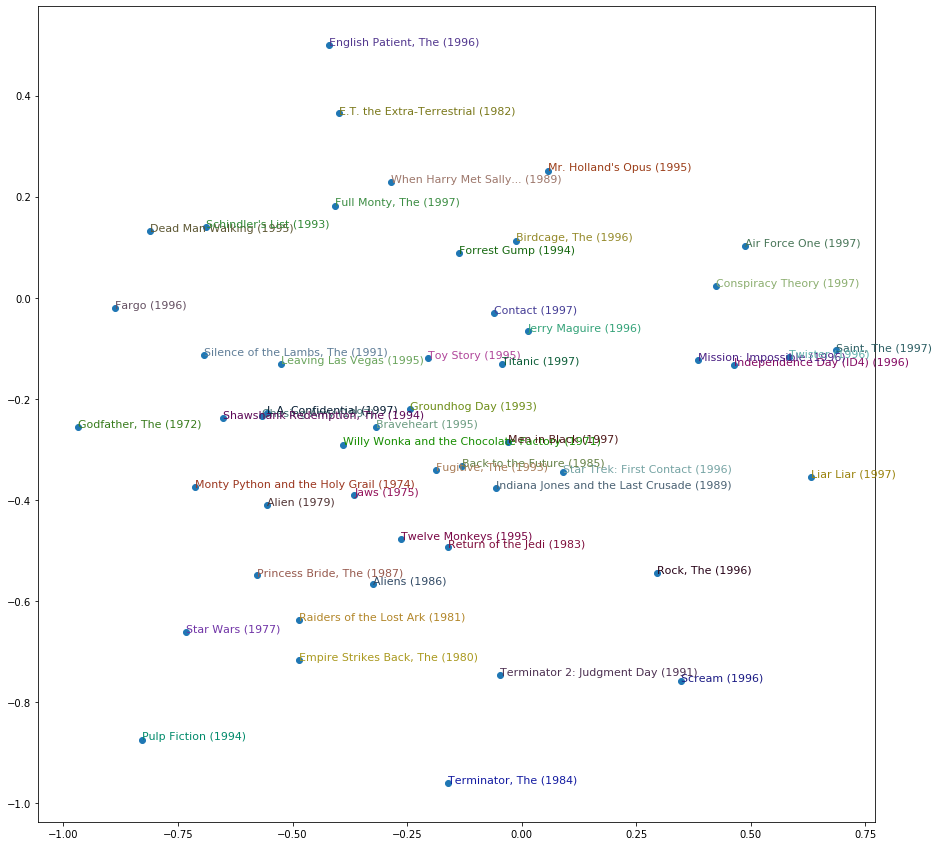

In [38]:
idxs = np.random.choice(len(top_movies), 50, replace=False) # random으로 50개를 골라서.
idxs = list(range(50))
X = fac0[idxs] # factor0와
Y = fac2[idxs] # factor2를 가져와서
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11) # 2차원 plot에 시각화하고, 그 영화 제목을 text로 찍는다.
plt.show()

## Comment:

- Collaborative Filtering(CF) 파트는 fastai에서 어떤 것을 다루려고 하는지 잘 모르겠다.
- 강의에선 cold start problem도 언급하고, 추천에 대한 내용도 다루었는데, user-based CF인지 item-based CF인지도 모르겠다.
- 코드를 전체적으로 보니, user-based CF인 것 같은데 확실하진 않고, collab_learner의 역할도 잘 모르겠다.]
- CF는 user가 시청한 영화 목록을 다른 user에게 추천하는 유사도를 계산하는 것으로, matrix 연산을 통해 만드는데 여기서 factor가 어떻게 구현되는지 불분명하게 기술이 된다.
- excel을 통해서 MatMul에 대한 다루고, weights와 bias를 계산하는 방식(embedding)을 설명하는데 사실상 엑셀에서 matrix multiplication을 하는 방법과 그 의미에 대해 다루며 선형대수학을 통한 행렬 연산의 의미를 다루는 느낌이지 어떻게 CF에서 동작하는지 이해가 잘 가지 않았다.

- fastai의 CollabLearner를 가지고 어떤 유사 추천목록을 만드는 것은 힘들 것 같다.
- CollabLearner의 코드를 열어서 봤는데, 어떻게 Embedding이 되는지 코드 이해가 쉽지 않았다. 아직까진 vision 파트에 대해서는 클리어하게 encapsulation된 느낌인데 Collab에 와서는 혼란이 더 생겨서 wrapping이 애매하게 되어있다는 느낌을 받았다.